# 00 Import libraries

In [16]:


import numpy as np 
import pandas as pd
import os
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils import resample
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import dump, load
import mlflow.sklearn
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
import sys
import seaborn as sns


from result_display import show_result, export_anomaly
from reject_anomalies import pred_baseon_threshold, make_use_reject_anomalies
from Feature_engineer import remove_unwanted_col, feature_engineer_steps




# 01 Loading dataset

In [17]:
transactions_df = pd.read_csv("data/transactions_df.csv")
terminal_profiles_df = pd.read_csv("data/terminal_profiles_table.csv")
customer_profiles_df = pd.read_csv("data/customer_profiles_table.csv")
join_terminal = pd.merge(transactions_df, terminal_profiles_df, on='terminal_id', how='inner') #join dataset base on key value
join_customer = pd.merge(join_terminal, customer_profiles_df, on='customer_id', how='inner')


In [18]:
print(join_customer.columns.tolist())

['transaction_id', 'post_ts', 'customer_id', 'bin_x', 'terminal_id', 'amt', 'entry_mode', 'fraud', 'fraud_scenario', 'lat_terminal', 'log_terminal', 'mcc', 'mean_amount', 'std_amount', 'mean_nb_tx_per_day', 'network_id', 'bin_y', 'lat_customer', 'log_customer', 'available_terminals', 'nb_terminals']


In [31]:
#creating sample file for client demo purpose
samle_file = transactions_df.sample(n=10000, random_state=42)
samle_file.to_csv('data/user_demo_data.csv', index=False)

# 02 feature engineering 



In [20]:
train_X,train_y = feature_engineer_steps(join_customer)

In [21]:
print(train_X.columns.tolist())

['transaction_id', 'post_ts', 'customer_id', 'bin_x', 'terminal_id', 'amt', 'lat_terminal', 'log_terminal', 'mcc', 'mean_amount', 'std_amount', 'mean_nb_tx_per_day', 'bin_y', 'lat_customer', 'log_customer', 'available_terminals', 'nb_terminals', 'location_different', 'using_available_terminals', 'timestamp', 'date', 'per_day_difference_count', 'mean_difference', 'entry_mode_Chip', 'entry_mode_Contactless', 'entry_mode_Swipe', 'network_id_A', 'network_id_D', 'network_id_M', 'network_id_V']


### remove unwanted columns of X - 
                         'bin_y',
                         'mcc',
                         'bin_x',
                         'customer_id', 
                         'available_terminals',
                         'terminal_id',
                         'timestamp',                     
                 'transaction_id'_tx_per_day',
                         'date',
                         'post_ts',
                         'using_available_terminals',
        difference_count',

In [22]:
train_X = remove_unwanted_col(train_X)
train_X

,amt,lat_terminal,log_terminal,mean_amount,std_amount,mean_nb_tx_per_day,lat_customer,log_customer,nb_terminals,location_different,per_day_difference_count,mean_difference,entry_mode_Chip,entry_mode_Contactless,entry_mode_Swipe,network_id_A,network_id_D,network_id_M,network_id_V
0,38.97,41.6196,8.8804,69.331619,34.665810,1.465526,41.4894,8.5813,8,0.269275,3,-30.361619,False,True,False,False,False,False,True
1,84.07,39.9841,7.9760,63.288956,31.644478,3.203733,40.0288,8.3337,6,0.354896,3,20.781044,False,True,False,False,True,False,False
2,113.18,38.1775,7.9678,70.981654,35.490827,3.334656,38.4349,7.8189,9,0.209961,4,42.198346,False,True,False,False,False,False,True
3,28.96,41.4863,9.3078,16.874338,8.437169,3.548954,41.7687,9.0176,6,0.066830,5,12.085662,True,False,False,False,False,True,False
4,65.45,38.1393,8.8370,91.312221,45.656110,3.229474,37.9586,8.9459,11,0.144199,4,-25.862221,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785303,79.79,40.2779,8.3579,52.436549,26.218275,3.823199,40.1618,7.8099,9,0.535560,1,27.353451,False,True,False,False,False,True,False
1785304,19.60,41.5019,8.0491,42.268027,21.134014,3.170458,41.1119,7.9758,6,0.383050,6,-22.668027,False,False,True,True,False,False,False
1785305,23.67,41.3494,8.9351,93.056281,46.528140,2.972050,41.2649,9.4552,6,0.513190,7,-69.386281,False,True,False,False,True,False,False
1785306,6.26,39.4052,8.0347,5.643105,2.821552,2.213253,39.3579,7.9013,8,0.124733,3,0.616895,True,False,False,True,False,False,False


# 03 Scaling Test and train X

In [23]:
# Assuming train_X is your feature matrix
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.05, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Finding Elbow coefficient that I found as 4

In [24]:

# wcss = []  # Within-cluster sum of squares
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans.fit(X_train_scaled)
#     wcss.append(kmeans.inertia_)

# # Plot the results to observe the 'elbow'
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')  # Within cluster sum of squares
# plt.show()

# 04 Training Model to test

In [25]:


# Choose the number of clusters based on your elbow method plot
def model_train(n_clusters, X_train_scaled):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=10, random_state=42)
    kmeans.fit(X_train_scaled)
    
    distances = kmeans.transform(X_train_scaled)
    closest_cluster_distance = np.min(distances, axis=1)

    ## Percentile as 95
    threshold = np.percentile(closest_cluster_distance, 95)

    y_pred = closest_cluster_distance > threshold
    return y_pred

In [26]:
y_pred = []
for i in range(4,5):
    y_pred.append(model_train(i, X_train_scaled))
    print(f'finished train N{i}')
print(y_pred)

finished train N4
[array([False, False, False, ..., False, False, False])]


Test result

In [27]:
# Define function to calculate accuracy
def calculate_accuracy(cm):
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    return accuracy * 100

In [28]:
# Define function to plot confusion matrix
def plot_confusion_matrix(y_train, anomalies, ax, accuracies):
    cm = confusion_matrix(y_train, anomalies)
    accuracy = calculate_accuracy(cm)
    accuracies.append(accuracy)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix (Accuracy: {accuracy:.2f}%)')


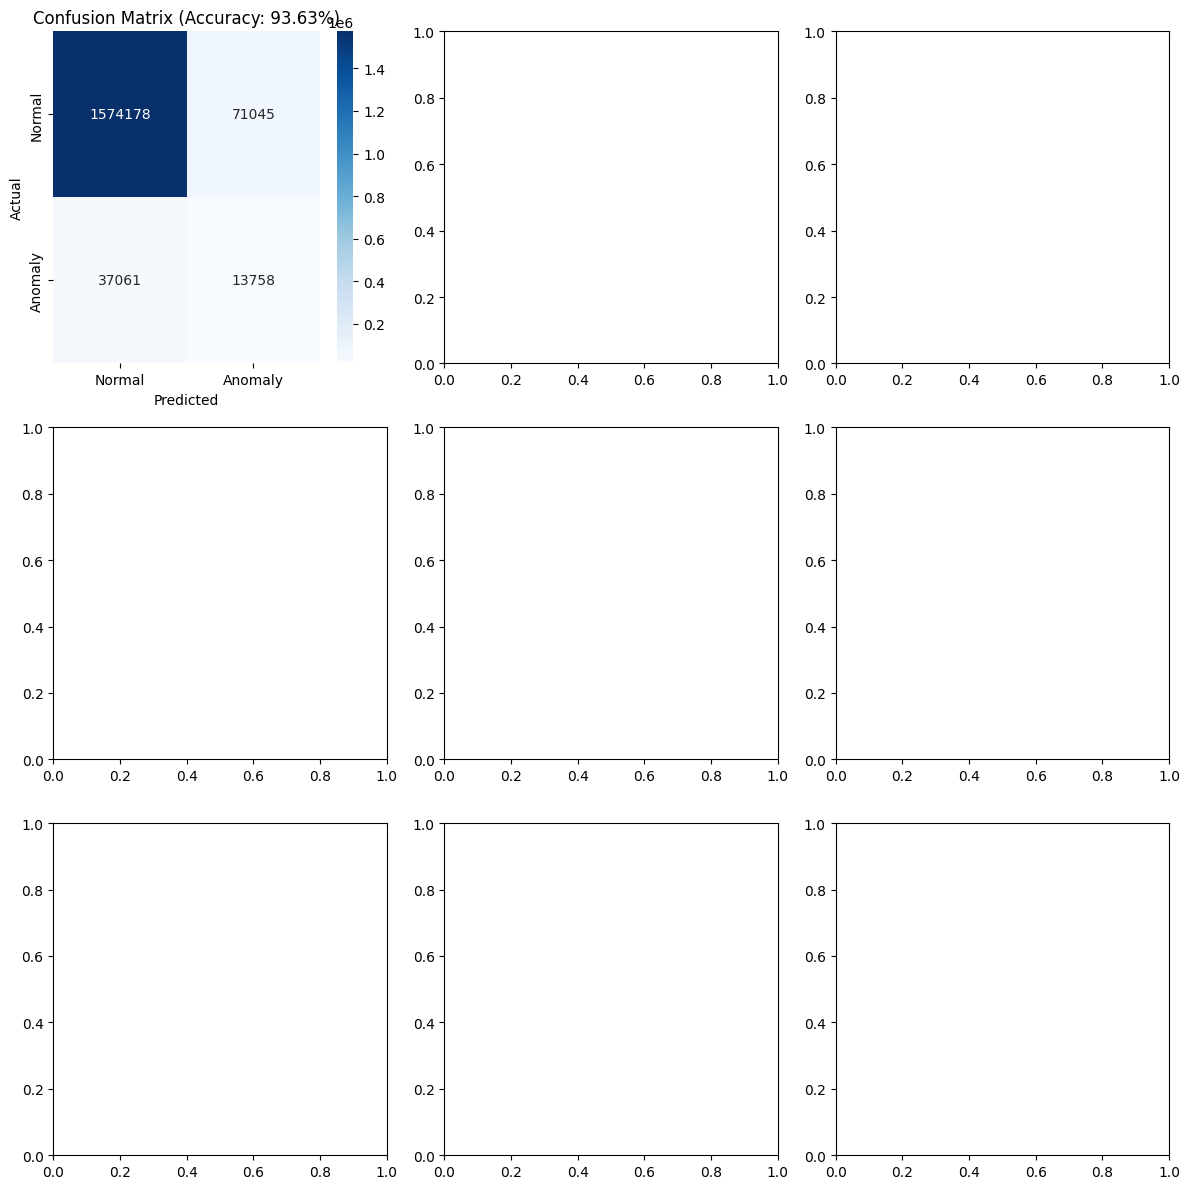

In [29]:
accuracies = []
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
for idx, pred in enumerate(y_pred):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    plot_confusion_matrix(y_train, pred, ax, accuracies)
plt.tight_layout()
plt.show()

# 05 Final Model output and save

In [30]:


n_clusters_optimal = 4
kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_optimal.fit(X_train_scaled)
dump(kmeans_optimal, 'saved_model/best_model_Kmeans.joblib')

['saved_model/best_model_Kmeans.joblib']